In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pprint
import warnings

from simulation.user_sessions import user_weekly_session_dist, user_weekly_sessions, simulate_users
from experiments.pre_test_analysis import required_sample_size, estimate_cuped_stats
from experiments.experiment import experiment
from evaluation.evaluate_experiments import evaluate_experiments, summarize_results
from evaluation.visualize_experiments import create_viz_stat_sig, create_viz_sample_size

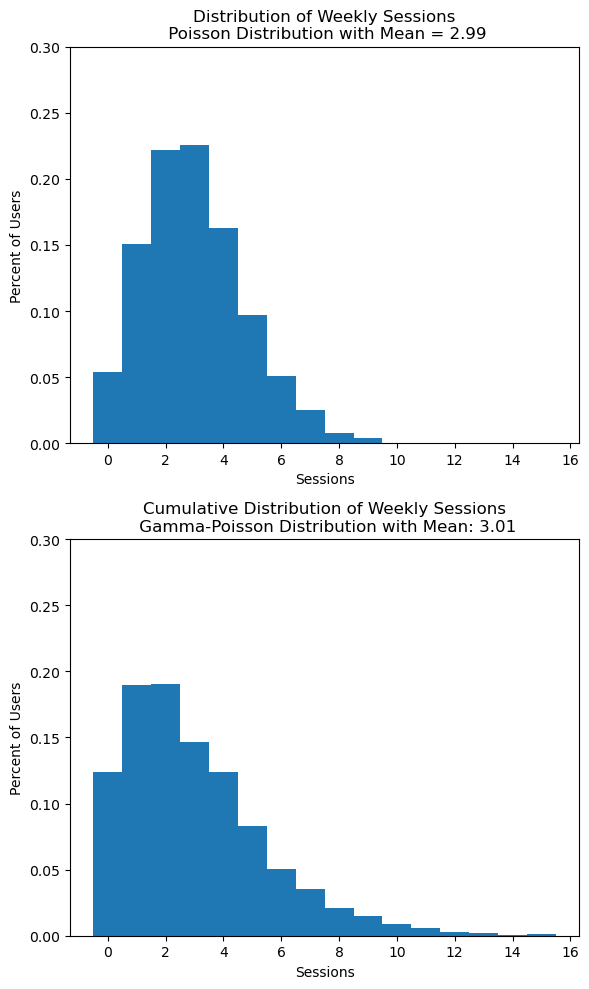

In [2]:
poisson_weekly_user_sessions = []
gamma_poisson_weekly_user_sessions = []

for _ in range(10000):
    lam = user_weekly_session_dist()
    poisson_sessions_capped = min(user_weekly_sessions(3), 15)
    poisson_weekly_user_sessions.append(poisson_sessions_capped)
    lam_sessions_capped = min(user_weekly_sessions(lam), 15)
    gamma_poisson_weekly_user_sessions.append(lam_sessions_capped)

poisson_mean = np.mean(poisson_weekly_user_sessions) 
gamma_poisson_mean = np.mean(gamma_poisson_weekly_user_sessions)

fig, axs = plt.subplots(2, 1, figsize=(6,10))

axs[0].hist(poisson_weekly_user_sessions, 
            bins=range(0, 17), 
            align='left', 
            density=True
)
axs[0].set_xlabel('Sessions')
axs[0].set_ylabel('Percent of Users')
axs[0].set_title('Distribution of Weekly Sessions\n Poisson Distribution with Mean = {:.2f}'.format(poisson_mean))
axs[0].set_ylim(0, 0.3)

axs[1].hist(gamma_poisson_weekly_user_sessions, 
            bins=range(0, 17), 
            align='left', 
            density=True
)
axs[1].set_xlabel('Sessions')
axs[1].set_ylabel('Percent of Users')
axs[1].set_title('Cumulative Distribution of Weekly Sessions\n Gamma-Poisson Distribution with Mean: {:.2f}'.format(gamma_poisson_mean))
axs[1].set_ylim(0, 0.3)

plt.tight_layout()
plt.show()

Both distributions produce a sample mean around 3. Using the gamma distribution  at $\alpha = 3$ and $\theta = 1$ to determine the poisson parameter creates a longer tail at a given mean than using poisson alone at $\lambda = 3$. I think the former better models the wider range of activity between different users, such as the existence of power users.

In [3]:
pre_c_users, post_c_users, pre_t_users, post_t_users = simulate_users(10000,4)

c_users = np.concatenate([pre_c_users, post_c_users], axis=1)
t_users = np.concatenate([pre_t_users, post_t_users], axis=1)

print('Mean User Sessions per Period (No Effect)')
print('Control:', np.mean(c_users))
print('Treatment:', np.mean(t_users))

pre_c_users, post_c_users, pre_t_users, post_t_users = simulate_users(10000,4,exp_effect=.5)

c_users = np.concatenate([pre_c_users, post_c_users], axis=1)
t_users = np.concatenate([pre_t_users, post_t_users], axis=1)

print(c_users)
print(t_users)

print('Mean User Sessions per Period (+50% Effect)')
print('Control:', np.mean(c_users))
print('Treatment:', np.mean(t_users))

Mean User Sessions per Period (No Effect)
Control: 2.954675
Treatment: 2.977825
[[2 2 4 ... 0 1 2]
 [0 0 0 ... 3 1 4]
 [2 0 3 ... 4 1 2]
 ...
 [1 0 0 ... 1 3 4]
 [1 1 0 ... 0 2 2]
 [2 2 0 ... 0 0 0]]
[[1 4 5 ... 7 4 5]
 [1 3 1 ... 2 6 4]
 [1 4 0 ... 1 2 4]
 ...
 [0 0 0 ... 0 0 0]
 [1 3 2 ... 2 5 5]
 [2 0 0 ... 2 3 2]]
Mean User Sessions per Period (+50% Effect)
Control: 3.012275
Treatment: 3.6558


Added simple random walk to model within user variation. Each time period applies a percent change on the poisson lambda equal to a sample from a normal distribution at $\sigma = .1$. Min global change is set at -66% and max global at +100%.

In [5]:

cuped_corrcoef, cuped_theta = estimate_cuped_stats(10000, 4)

print('Estimated CUPED correlation coefficient: {:.3f}'.format(cuped_corrcoef))
print('Estimated CUPED theta: {:.3f}\n'.format(cuped_theta))

pre_c_users, post_c_users, pre_t_users, post_t_users = simulate_users(100000,4,exp_effect=.03)
pre_exp_users_sum = np.vstack([pre_c_users, pre_t_users]).sum(axis=1)

t_test_n, t_test_cuped_n, seq_test_n, seq_test_cuped_n = required_sample_size(pre_exp_users_sum, cuped_corr_coef=cuped_corrcoef)
print(f'T-test required sample size: {t_test_n}')
print(f'T-test with CUPED required sample size: {t_test_cuped_n}')
print(f'Group sequential test required sample size: {seq_test_n}')
print(f'Group sequential test with CUPED required sample size: {seq_test_cuped_n}')

Estimated CUPED correlation coefficient: 0.754
Estimated CUPED theta: 0.893

T-test required sample size: 20197
T-test with CUPED required sample size: 8700
Group sequential test required sample size: 20846
Group sequential test with CUPED required sample size: 8980


I will be using an estimated CUPED $\theta$ rather than calculating using actual experiment data because 1. Treatment effects are heterogenous so including treatment in the covariance creates issues; 2. Re-calculating theta during each look in sequential testing will increase the false positive rate.

I estimated using a sample size of 10000. ~.75 correlation coefficient between pre- and post-experiment sessions over a 4 week period seems reasonable. It creates a ~56% decrease in required sample size when using CUPED. Group sequential test is only slightly higher than t-test since I will be using the O'Brien-Flemming method.

In [6]:
exp = experiment(
    pre_c_user_sessions=pre_c_users,
    post_c_user_sessions=post_c_users,
    pre_t_user_sessions=pre_t_users,
    post_t_user_sessions=post_t_users,
    t_test_n=t_test_n,
    t_test_cuped_n=round(t_test_cuped_n * 1.1),
    seq_test_n=seq_test_n,
    seq_test_cuped_n=round(seq_test_cuped_n * 1.1),
    cuped_theta=cuped_theta
)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    exp.create_test_groups()
    exp.create_test_entries()
    exp.create_test_entry_data()
    exp.run_experiment()
    pprint.pprint(exp.results)

{'seq': {'p_value': 0.01, 'sample_size': 31270, 'significance': 1},
 'seq_cuped': {'p_value': 0.0, 'sample_size': 19756, 'significance': 1},
 'ttest': {'p_value': 0.001, 'sample_size': 40394, 'significance': 1},
 'ttest_cuped': {'p_value': 0.0, 'sample_size': 19140, 'significance': 1}}


Simulated with 3% true treatment effect. Adding extra 10% to calculated minimum sample size for CUPED models to account for the larger estimation of variance.

In [7]:
results = evaluate_experiments()

In [8]:
summarized_results = summarize_results(results)

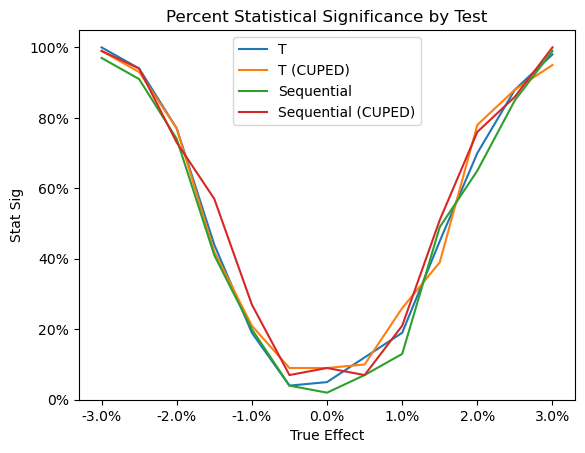

In [12]:
fig = create_viz_stat_sig(summarized_results)
plt.show()

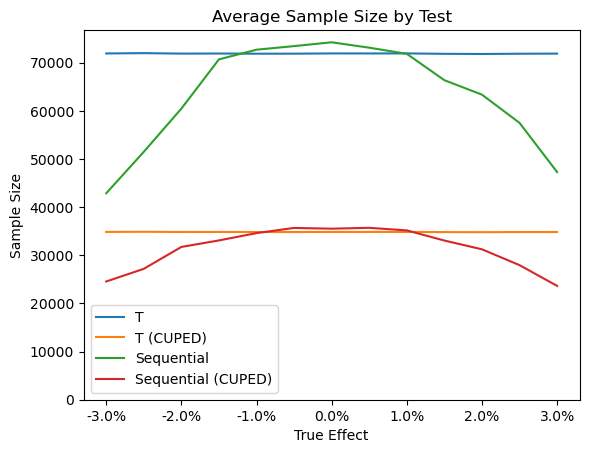

In [10]:
fig2 = create_viz_sample_size(summarized_results)
plt.show()